In [182]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [183]:
## Initialize arrays

kNumBits = 16
kNumSamples = 10000
kNumRetries = 3

# Random noise
use_seed = True

if use_seed:
    rng = np.random.default_rng(seed = 42)
else:
    rng = np.random.default_rng(12345)

ADCbits = np.zeros(kNumBits)
for i in range (0, kNumBits):
    ADCbits[i] = (1 << int(i))
Tbits = np.divide(1, (np.log(np.divide(np.divide(20000, (30000/ADCbits - 1)), 10000)) / 3435) + 1/298.15) - 273.15

number_of_bit_flips = rng.integers(low = 1, high = 2, size=(3, 10000))
bit_flip_location = rng.integers(low = 0, high = 16, size=(3, 10000, 5))
bit_flip_value = rng.integers(low = 0, high = 2, size=(3, 10000, 5))

RToriginal_vec = np.linspace(860, 190000, 10000)
RToriginal = np.array([RToriginal_vec, RToriginal_vec, RToriginal_vec])

ADCoriginal = np.uint16(np.divide(RToriginal, RToriginal + 20000)*30000)
ADCnoise = np.uint16(np.divide(RToriginal, RToriginal + 20000)*30000)

for i in range(0, ADCnoise.shape[0]):
    for j in range(0, ADCnoise.shape[1]):
        for k in range(0, number_of_bit_flips[i,j]):
            ADCnoise[i,j] = ADCnoise[i,j] ^ (bit_flip_value[i,j,k] << bit_flip_location[i,j,k])

Toriginal = np.divide(1, (np.log(np.divide(np.divide(20000, (30000/ADCoriginal - 1)), 10000)) / 3435) + 1/298.15) - 273.15
Tnoise = np.divide(1, (np.log(np.divide(np.divide(20000, (30000/ADCnoise - 1)), 10000)) / 3435) + 1/298.15) - 273.15


C:\Users\Marco.Nunez\AppData\Local\Temp\ipykernel_2316\488421322.py:18: RuntimeWarning: invalid value encountered in log
  Tbits = np.divide(1, (np.log(np.divide(np.divide(20000, (30000/ADCbits - 1)), 10000)) / 3435) + 1/298.15) - 273.15
C:\Users\Marco.Nunez\AppData\Local\Temp\ipykernel_2316\488421322.py:36: RuntimeWarning: invalid value encountered in log
  Tnoise = np.divide(1, (np.log(np.divide(np.divide(20000, (30000/ADCnoise - 1)), 10000)) / 3435) + 1/298.15) - 273.15


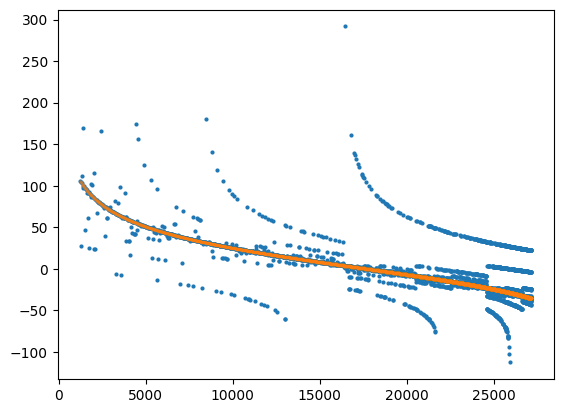

In [184]:
c = np.arange(10000)
axs = plt.subplots()
# plt.scatter(RToriginal[0,:], Tnoise[0,:])
# plt.scatter(RToriginal[0,:], Toriginal[0,:])

plt.scatter(ADCoriginal[0,:], Tnoise[0,:], s=9, linewidths=0)
plt.scatter(ADCoriginal[0,:], Toriginal[0,:], alpha=0.3, s=6, linewidths=0)

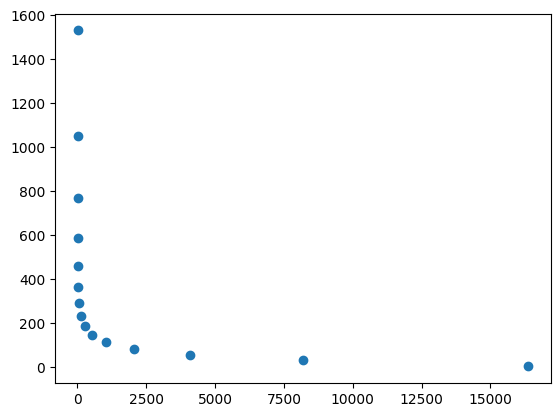

In [185]:
axs = plt.subplots()
plt.scatter(ADCbits, Tbits)

In [186]:
## Generate abs difference matrix
Tbar = np.mean(Tnoise, axis=0)
ADCbar = np.mean(ADCnoise, axis=0)

# Measure
Tdiff = np.zeros((kNumRetries, kNumSamples))
ADCdiff = np.zeros((kNumRetries, kNumSamples))

Tdiff[0,:] = np.abs(Tnoise[0, :] - Tbar)
Tdiff[1,:] = np.abs(Tnoise[1, :] - Tbar)
Tdiff[2,:] = np.abs(Tnoise[2, :] - Tbar)

ADCdiff[0,:] = np.abs(ADCnoise[0, :] - ADCbar)
ADCdiff[1,:] = np.abs(ADCnoise[1, :] - ADCbar)
ADCdiff[2,:] = np.abs(ADCnoise[2, :] - ADCbar)

In [198]:
## Generate results

Tgood_flag = Tdiff <= 6186
ADCgood_flag = ADCdiff <= 3000

Tans = np.zeros(kNumSamples)
Trejects = np.zeros(kNumSamples)

ADCans = np.zeros(kNumSamples)
ADCrejects = np.zeros(kNumSamples)

good_vals = 0
total = 0

for i in range(0, kNumSamples):
    for k in range(0,kNumRetries):
        if(Tgood_flag[k,i]):
            good_vals += 1
            total += Tnoise[k,i]
    if (good_vals != 0):
        Tans[i] = total/good_vals
    else:
        Tans[i] = np.NaN
    Trejects[i] = kNumRetries-good_vals
    good_vals = 0
    total = 0

good_vals = 0
total = 0

for i in range(0, kNumSamples):
    for k in range(0,kNumRetries):
        if(ADCgood_flag[k,i]):
            good_vals += 1
            total += ADCnoise[k,i]
    if (good_vals != 0):
        ADCans[i] = np.uint16(total/good_vals) & 0x7FFF
    else:
        ADCans[i] = np.NaN
    ADCrejects[i] = kNumRetries-good_vals
    good_vals = 0
    total = 0



Tans = np.divide(1, (np.log(np.divide(np.divide(20000, (30000/ADCans - 1)), 10000)) / 3435) + 1/298.15) - 273.15

C:\Users\Marco.Nunez\AppData\Local\Temp\ipykernel_2316\2490328549.py:46: RuntimeWarning: invalid value encountered in log
  Tans = np.divide(1, (np.log(np.divide(np.divide(20000, (30000/ADCans - 1)), 10000)) / 3435) + 1/298.15) - 273.15


In [199]:
## Count NaNs
Tnans = 0
nan_values = 0

for j in range(0, kNumSamples):
    if(np.isnan(Tans[j])):
        nan_values += 1
    
Tnans = nan_values

ADCnans = 0
nan_values = 0

for j in range(0, kNumSamples):
    if(np.isnan(ADCans[j])):
        nan_values += 1
    
ADCnans = nan_values

print(ADCnans)

1675


In [200]:
## Rejects per bit
# Average
Treject_mean = np.mean(Trejects)
# Max
Treject_max = np.max(Trejects)
# Min
Treject_min = np.min(Trejects)

print("Mean Reject samples: " + str(Treject_mean))
print("Max Reject samples: " + str(Treject_max))
print("Min Reject samples: " + str(Treject_min))


# Average
ADCreject_mean = np.mean(ADCrejects)
# Max
ADCreject_max = np.max(ADCrejects)
# Min
ADCreject_min = np.min(ADCrejects)

print("Mean Reject samples: " + str(ADCreject_mean))
print("Max Reject samples: " + str(ADCreject_max))
print("Min Reject samples: " + str(ADCreject_min))

Mean Reject samples: 0.6186
Max Reject samples: 3.0
Min Reject samples: 0.0
Mean Reject samples: 0.0
Max Reject samples: 0.0
Min Reject samples: 0.0


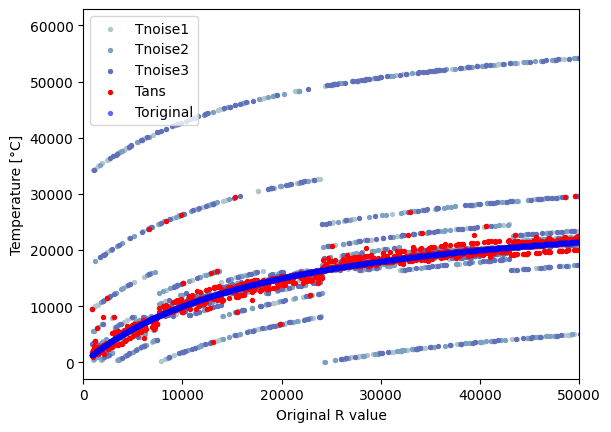

In [201]:
## Plot of Processed Data
fig, axs = plt.subplots()
colormap = mpl.colormaps['twilight'].resampled(120)
c = colormap(np.linspace(0,1,24))


plt.scatter(RToriginal_vec, ADCnoise[0,:], s=8, color=c[2])
plt.scatter(RToriginal_vec, ADCnoise[1,:], s=8, color=c[4])
plt.scatter(RToriginal_vec, ADCnoise[2,:], s=8, color=c[6])
plt.scatter(RToriginal_vec, ADCans, s=8, color='r')
# plt.scatter(RToriginal_vec, Tbar, s=8, color='r', alpha=0.3)
plt.scatter(RToriginal_vec, ADCoriginal[0,:], s=8, color='b', alpha=0.5)
plt.xlabel("Original R value")
plt.ylabel("Temperature [°C]")
plt.xlim([0, 50000])
plt.legend(["Tnoise1", "Tnoise2", "Tnoise3", "Tans",  "Toriginal"], loc='best')



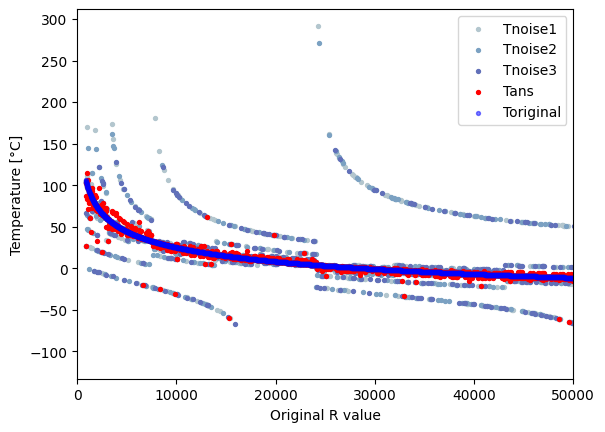

In [202]:
## Plot of Processed Data
fig, axs = plt.subplots()
colormap = mpl.colormaps['twilight'].resampled(120)
c = colormap(np.linspace(0,1,24))


plt.scatter(RToriginal_vec, Tnoise[0,:], s=8, color=c[2])
plt.scatter(RToriginal_vec, Tnoise[1,:], s=8, color=c[4])
plt.scatter(RToriginal_vec, Tnoise[2,:], s=8, color=c[6])
plt.scatter(RToriginal_vec, Tans, s=8, color='r')
# plt.scatter(RToriginal_vec, Tbar, s=8, color='r', alpha=0.3)
plt.scatter(RToriginal_vec, Toriginal[0,:], s=8, color='b', alpha=0.5)
plt.xlabel("Original R value")
plt.ylabel("Temperature [°C]")
plt.xlim([0, 50000])
plt.legend(["Tnoise1", "Tnoise2", "Tnoise3", "Tans",  "Toriginal"], loc='best')

In [192]:
## Check |Xi - Xbar|

ADCcheck = np.abs(ADCans - ADCbar)


for i in range(0,ADCcheck.shape[0]):
    if np.isnan(ADCcheck[i]):
        ADCcheck[i] = 0

ADCmax_diff = np.max(ADCcheck)
print(ADCmax_diff)

6144.0


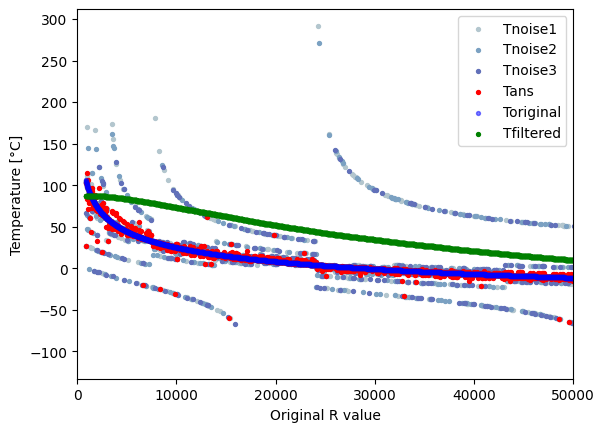

In [206]:

Tfiltered = np.zeros(kNumSamples)
Tfiltered[0] = Tans[0]
lam = 0.001

for i in range(1, kNumSamples):
    if (np.isnan(Tans[i])):
        Tfiltered[i] = Tfiltered[i-1]
    else:
        Tfiltered[i] = lam * Tans[i] + (1 - lam) * Tfiltered[i-1]

## Plot of Processed Data
fig, axs = plt.subplots()
colormap = mpl.colormaps['twilight'].resampled(120)
c = colormap(np.linspace(0,1,24))


plt.scatter(RToriginal_vec, Tnoise[0,:], s=8, color=c[2])
plt.scatter(RToriginal_vec, Tnoise[1,:], s=8, color=c[4])
plt.scatter(RToriginal_vec, Tnoise[2,:], s=8, color=c[6])
plt.scatter(RToriginal_vec, Tans, s=8, color='r')
plt.scatter(RToriginal_vec, Toriginal[0,:], s=8, color='b', alpha=0.5)
plt.scatter(RToriginal_vec, Tfiltered, s=8, color='g')
plt.xlabel("Original R value")
plt.ylabel("Temperature [°C]")
plt.xlim([0, 50000])
plt.legend(["Tnoise1", "Tnoise2", "Tnoise3", "Tans", "Toriginal", "Tfiltered"], loc='best')